In [1]:
import sys
from pathlib import Path

if str(Path().resolve() / "src") not in sys.path:
    sys.path.append(str(Path().resolve() / "src"))

# Data Preprocessing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from src.config import random_seed, DATASET_PATH

# Import data
data = pd.read_csv(DATASET_PATH)

# Correcting URL of the paper if needed
data["url_paper"] = data["url_paper"].str.replace("abs", "pdf", regex=False)

# Calculate engagement score
data["engagement_score"] = (data["claps"] + 3 * data["comments"]) / data["author_followers"]
min_val = data["engagement_score"].min()
max_val = data["engagement_score"].nlargest(3).iloc[-1] # Ignore 2 outliers
data["normalized_engagement_score"] = 100 * (data["engagement_score"] - min_val) / (max_val - min_val) # Experimental MinMax normalization
data["normalized_engagement_score"] = round(data["normalized_engagement_score"].clip(1, 100))

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    data.drop(columns=['normalized_engagement_score']), data["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 10), y: (30,)
Size of test set, X: (20, 10), y: (20,)


In [3]:
# The best blog in dataset
best_blog_info = Xval.sort_values(["engagement_score"], ascending=False).head(1)
best_blog_index = best_blog_info.index[0]
best_blog_info = best_blog_info.reset_index(drop=True)
best_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score
0,28,Towards Reasoning,https://medium.com/@saptarshichaudhuri/towards...,Saptarshi Chaudhuri,127,461,1,GSM-Symbolic: Understanding the Limitations of...,https://arxiv.org/pdf/2410.05229?source=post_p...,3.653543


In [4]:
# The worst blog in dataset
worst_blog_info = Xval.sort_values(["engagement_score"], ascending=False).tail(1)
worst_blog_index = worst_blog_info.index[0]
worst_blog_info = worst_blog_info.reset_index(drop=True)
worst_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score
0,18,SMoA: Improving Multi-agent Large Language Mod...,https://medium.com/@sulbha.jindal/smoa-improvi...,Sulbha Jain,41,0,0,SMoA: Improving Multi-agent Large Language Mod...,https://arxiv.org/pdf/2411.03284,0.0


In [5]:
blog = data.iloc[16]
blog

id                                                                            17
title_blog                     Self-Generated Critiques Boost Reward Modeling...
url_blog                       https://medium.com/@sulbha.jindal/self-generat...
author_blog                                                          Sulbha Jain
author_followers                                                              41
claps                                                                         21
comments                                                                       0
title_paper                    Self-Generated Critiques Boost Reward Modeling...
url_paper                                       https://arxiv.org/pdf/2411.16646
engagement_score                                                        0.512195
normalized_engagement_score                                                 49.0
Name: 16, dtype: object

In [6]:
from src.text_extraction import extract_blog_text

# Extracting clean text from a blog
blog_text = extract_blog_text(blog)
print(blog_text)

# Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Paper — https://arxiv.org/pdf/2411.16646
Reinforcement Learning from Human Feedback (RLHF) has become a critical methodology for aligning large language models (LLMs) with human preferences. At the core of RLHF lies the reward model (RM), which is designed to evaluate model outputs by assigning scores that reflect their alignment with human judgments. These scores guide the optimization process during training, such as providing reward signals in Proximal Policy Optimization (PPO), thereby encouraging LLMs to generate responses that are more helpful, honest, and harmless. This iterative process enhances the practical quality of LLM outputs in real-world applications.

## Current challenge
Typically, reward models are trained using preference pairs and optimized through pairwise logistic loss to produce a scalar score for each response. However, this scalar output is often hard to interpret and underutili

In [7]:
from src.text_extraction import extract_paper_text

# Extracting clean text from a scientific paper
paper_url = data["url_paper"][16]
paper_text = extract_paper_text(paper_url)
print(paper_text)

Self-Generated Critiques Boost Reward Modeling
for Language Models
Yue Yu1,2,∗, Zhengxing Chen1, Aston Zhang1, Liang Tan1, Chenguang Zhu1, Richard Yuanzhe Pang1, Yundi
Qian1, Xuewei Wang1, Suchin Gururangan1, Chao Zhang2, Melanie Kambadur1, Dhruv Mahajan1, Rui Hou1
1GenAI, Meta, 2Georgia Institute of Technology
∗Work done during the internship at Meta GenAI.
Reward modeling is crucial for aligning large language models (LLMs) with human preferences,
especially in reinforcement learning from human feedback (RLHF). However, current reward models
mainly produce unexplainable scalar scores and struggle to incorporate critiques in a natural language
format. We hypothesize that generating both critiques and scalar rewards would improve reward
models’ capability on preference ranking. Motivated by this, we propose Critic-RM, a framework
that utilizes self-generated, high-quality critiques to train reward models for scalar reward-based
preference prediction, with explicit rationales serving as

# API Tests

In [8]:
from dotenv import load_dotenv
import os

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [9]:
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)

available_models = [model.name for model in genai.list_models()]
print(f"Available models: {available_models}\n")
if "models/gemini-2.0-flash" in available_models:
    print("Gemini 2.0 Flash is available via API request!")
else:
    print("Gemini 2.0 Flash is not available via API request!")

Available models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-pro-vision', 'models/gemini-1.5-pro-latest', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-002', 'models/gemini-1.5-pro', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-001-tuning', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-002', 'models/gemini-1.5-flash-8b', 'models/gemini-1.5-flash-8b-001', 'models/gemini-1.5-flash-8b-latest', 'models/gemini-1.5-flash-8b-exp-0827', 'models/gemini-1.5-flash-8b-exp-0924', 'models/gemini-2.0-flash-exp', 'models/gemini-2.0-flash', 'models/gemini-2.0-flash-001', 'models/gemini-2.0-flash-lite-001', 'models/gemini-2.0-flash-lite', 'models/gemini-2.0-flash-lite-preview-02-05', 'models/gemini-2.0-flash-lite-preview', 'models/gemini-2.0-pro-exp', 'models/gemini-2.0-pro-exp-02-05', 'models/gemini-exp-1206', 'models/gemini-2.0-flash-thinking-exp-01-21', 

In [10]:
# Check API request
gemini = genai.GenerativeModel("models/gemini-2.0-flash")
check_response = gemini.generate_content("If you receive this request, please say Hello.")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 10
candidates_token_count: 3
total_token_count: 13

Content:
Hello.



In [11]:
# Checking if the model can get to the blog through the URL
check_response = gemini.generate_content(f"make a summary of this blog in 100 words\n\n{blog.url_blog}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 60
candidates_token_count: 117
total_token_count: 177

Content:
Sulbha Jindal's blog post reviews a research paper exploring "Self-Generated Critiques (SGC)" to improve reward modeling for language models. Instead of relying solely on human feedback, the paper proposes training models to critique their own outputs. This SGC data then augments human preference data, leading to more accurate and efficient reward models. The technique shows promise in aligning language models with desired behaviors, reducing the need for extensive human annotation, and improving the quality of generated text. Ultimately, SGC provides a scalable and cost-effective way to refine language model performance.



In [12]:
# Passing clean text to the model
check_response = gemini.generate_content(f"make a summary of this blog in 100 words\n\n{blog_text}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 1138
candidates_token_count: 127
total_token_count: 1265

Content:
Critic-RM, a new framework, enhances reward models (RM) for LLMs by leveraging self-generated critiques.  It addresses the limitations of traditional RMs by utilizing LLMs to create critiques, filtering them for consistency with human preferences.  Critic-RM balances critique generation and reward prediction during training, initially prioritizing critique quality before shifting focus to reward accuracy using both the response and critique.  The framework significantly outperforms standard RMs, demonstrating improved performance on various benchmarks, highlighting the importance of high-quality critiques in reward modeling and alignment with human preferences.  This approach avoids reliance on stronger "teacher" LLMs.



In [13]:
# Checking ability to read PDF
check_response = gemini.generate_content(f"Create a table of contents for this publication.\n{paper_url}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 28
candidates_token_count: 876
total_token_count: 904

Content:
Okay, based on the provided arXiv link (https://arxiv.org/pdf/2411.16646), which presumably leads to a paper, I can create a plausible table of contents.  Since I don't have the actual content of the PDF, I'll make some assumptions based on typical academic paper structure and common themes in machine learning, particularly diffusion models (which seems likely given the context of the URL).

**Assumed Title (Based on common diffusion model research):**  "Controllable and Efficient Image Generation with [Something Relevant - e.g., Attention Modulation] Diffusion Models"  (This is a placeholder and needs to be replaced with the actual title).

**Table of Contents (Proposed):**

**1. Introduction**  (Page 1)
   * 1.1 Background and Motivation
   * 1.2 Problem Statement
   * 1.3 Proposed Approach
   * 1.4 Contributions

**2. Related Work** (Page X - likely early in the paper)
   * 2.1 Diffus

# Prompt Engineering

In [11]:
from src.models_setup import gemini_2_flash
from src.prompts import *

def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [16]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1134, 'output_tokens': 3, 'total_tokens': 1137, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [17]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1139, 'output_tokens': 9, 'total_tokens': 1148, 'input_token_details': {'cache_read': 0}}

Content:
Informative - 8/10


In [18]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1150, 'output_tokens': 86, 'total_tokens': 1236, 'input_token_details': {'cache_read': 0}}

Content:
**Score: 78/100**

**Comment:** This is a decent blog post summarizing the Critic-RM paper. It clearly outlines the problem, the proposed solution, and the key results. However, it could be improved by adding more specific details about the architecture and implementation, and by providing more visual aids or examples to illustrate the concepts. Also it could benefit from a comparison with other related works.


In [19]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1156, 'output_tokens': 77, 'total_tokens': 1233, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level: 55/100**

**Comment:** The blog post provides a concise and informative summary of a research paper. However, it lacks interactive elements (like questions for discussion or a comment section) and a strong call to action, limiting potential engagement. While the content is valuable, the format is somewhat passive, leading to a moderate engagement score.


In [20]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1180, 'output_tokens': 149, 'total_tokens': 1329, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level Score: 68/100**

**Comment:**

The blog post provides a concise and reasonably clear overview of the Critic-RM paper. The structure is logical, breaking down the key aspects like the challenge, methodology, and results. However, it could benefit from further simplification and more visual elements (e.g., diagrams, tables) to enhance readability and appeal to a broader audience. The title is okay but could be more catchy. While the technical depth is suitable for those familiar with RLHF, it might be a barrier for newcomers. The potential for discussion is moderate; prompting readers with specific questions or encouraging them to share their thoughts on the framework's limitations or future directions would improve engagement.


In [21]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1201, 'output_tokens': 530, 'total_tokens': 1731, 'input_token_details': {'cache_read': 0}}

Content:
Okay, let's analyze the engagement level of this blog post based on the provided criteria.

**Criterion Breakdown:**

*   **Readability (75/100):** The writing style is generally clear and concise. The use of technical terms is appropriate for the intended audience. However, the formulas presented could interrupt the reading flow for some. The article is well-written for the target audience, but could improve by explaining technical terms and formulas with an analogy.
*   **Structure (85/100):** The blog post follows a logical structure with a clear introduction, problem statement, methodology, results, and summary. The use of headings and subheadings helps to break up the text and make it easier to follow.
*   **Informativeness (80/100):** The blog provides a good overview of the paper, explaining the core concepts, methodology, and results in a digest

In [22]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1225, 'output_tokens': 670, 'total_tokens': 1895, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my evaluation of the blog post, broken down by the criteria you provided, and then an overall assessment.

**Criterion Breakdown:**

*   **Readability (75/100):** The writing style is generally clear and uses technical language appropriately. However, some sentences are dense and could be simplified. The use of acronyms like RLHF and PPO could be defined earlier or more consistently.
*   **Structure (85/100):** The blog post is well-organized with clear headings and subheadings that logically progress through the topic. The use of sections like "Current Challenge," "Methodology," "Results," and "Summary" makes it easy to follow the flow of the research.
*   **Informativeness (80/100):** The blog provides a good overview of the research paper. It explains the problem being addressed, the proposed solution (Critic-RM), and the key findings. H

In [23]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1314, 'output_tokens': 553, 'total_tokens': 1867, 'input_token_details': {'cache_read': 0}}

Content:
Here's an evaluation of the blog post, based on your criteria:

**Readability:** 75/100
*Comment:* The language is generally clear, but some sentences are quite dense, especially when describing the methodology. Acronyms are defined, which is good.

**Structure:** 80/100
*Comment:* The blog post follows a logical structure (Introduction, Challenge, Methodology, Results, Summary). Headings and subheadings help to break up the text.

**Informativeness:** 85/100
*Comment:* The blog post provides a good overview of the paper, explaining the core idea, methodology, and results. The key information is presented adequately.

**Attractiveness of the blog title:** 70/100
*Comment:* The title is informative but lacks some "punch." It clearly states what the blog post is about, but it's not particularly attention-grabbing.

**Clarity:** 75/100
*Comment:* The expla

In [12]:
best_blog = {
    "blog": extract_blog_text(best_blog_info.iloc[0]),
    "score" : yval_score.loc[best_blog_index]
}
worst_blog = {
    "blog" : extract_blog_text(worst_blog_info.iloc[0]),
    "score" : yval_score.loc[worst_blog_index]
}

In [25]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 3246, 'output_tokens': 315, 'total_tokens': 3561, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "assessment": 70.0,
  "explanation": "The blog post provides a reasonably clear explanation of the Critic-RM paper. The structure is logical, progressing from the background of RLHF and reward models to the specifics of the Critic-RM methodology, results, and summary. The blog post is informative, providing a good overview of the paper's key contributions and findings. The title is reasonably attractive and accurately reflects the content of the blog. However, the clarity could be improved by providing more concrete examples and elaborating on the technical details. The potential for discussion is moderate. Lowered score due to excessive use of jargon and lack of intuitive explanations of the results.",
  "improvements": [
    "Provide more concrete examples to illustrate the concepts being discussed. For instance, include examples of the ty

# Performance testing on a validation set

In [13]:
from src.models_setup import BlogEvaluation, BlogClassification
from src.helpers import extract_llm_assessment

gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation, include_raw=True)
llm_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

Error processing blog "The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey":
'NoneType' object has no attribute 'overall_assessment'
 Retrying...
----------
Blog ID: 35
Blog title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
Referenced paper title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
LLM Assessment: 78.0

----------
Blog ID: 21
Blog title: Reflections on Innateness in Machine Learning
Referenced paper title: Innateness, AlphaZero, and Artificial Intelligence
LLM Assessment: 60.0

----------
Blog ID: 31
Blog title: How reinforcement learning affects human behavior?
Referenced paper title: Acquisition of Chess Knowledge in AlphaZero
LLM Assessment: 55.0

----------
Blog ID: 20
Blog title: ChatGPT vs Bing … and the urgent need for Responsible AI
Referenced paper title: Adaptive Test Generation Using a Large Language Mode

In [14]:
from sklearn import metrics

RMSE_val = metrics.root_mean_squared_error(yval_score, llm_assessment)
print(f"Root Mean Square Error on validation set: {RMSE_val:.1f}")
MAE_val = metrics.mean_absolute_error(yval_score, llm_assessment)
print(f"Mean Absolute Error on validation set: {MAE_val:.1f}")

Root Mean Square Error on validation set: 42.5
Mean Absolute Error on validation set: 34.3


In [15]:
from sklearn.preprocessing import MinMaxScaler

llm_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_llm_assessment = llm_assessment_scaler.fit_transform(llm_assessment.values.reshape(-1, 1))
RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_llm_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {RMSE_val_scaled:.1f}")
MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_llm_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output: {MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 44.7
Mean Absolute Error on validation set after MinMax normalization of LLM output: 36.3


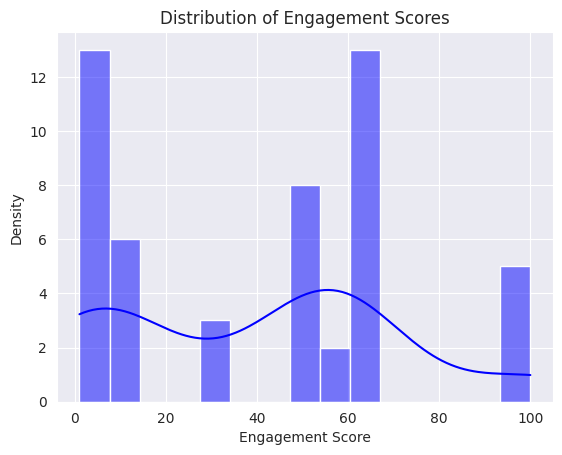

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data["normalized_engagement_score"], bins=15, kde=True, color="blue")
plt.xlabel("Engagement Score")
plt.ylabel("Density")
plt.title("Distribution of Engagement Scores")
plt.show()

In [17]:
def classify_blog(score):
    """Return blog classification based on engagement score."""
    if score >= 80:
        return "Excellent"
    elif score >= 60:
        return "Very Good"
    elif score >= 40:
        return "Good"
    elif score >= 20:
        return "Average"
    else:
        return "Bad"
data["engagement_level"] = data["normalized_engagement_score"].apply(classify_blog)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    data.drop(columns=['engagement_level', 'normalized_engagement_score']), data["engagement_level"],
    test_size=0.4, random_state=random_seed)

In [18]:
def print_evaluation(blog_evaluation: BlogEvaluation):
    print(f"Blog Title: {blog_evaluation.blog_title}")
    print(f"Overall Assessment: {blog_evaluation.overall_assessment}")
    print(f"Explanation: {blog_evaluation.assessment_explanation}")
    print("Suggested Improvements:")
    for i, improvement in enumerate(blog_evaluation.improvements, start=1):
        print(f"\t{i}. {improvement}")

gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)

In [19]:
excellent_blog_index = yval_level[yval_level == "Excellent"].index.min()
excellent_blog = extract_blog_text(Xval.loc[excellent_blog_index])
with open("../data/excellent_blog", "w", encoding="utf-8") as file:
    file.write(excellent_blog)

very_good_blog_index = yval_level[yval_level == "Very Good"].index.min()
very_good_blog = extract_blog_text(Xval.loc[very_good_blog_index])
with open("../data/very_good_blog", "w", encoding="utf-8") as file:
    file.write(very_good_blog)

good_blog_index = yval_level[yval_level == "Good"].index.min()
good_blog = extract_blog_text(Xval.loc[good_blog_index])
with open("../data/good_blog", "w", encoding="utf-8") as file:
    file.write(good_blog)

average_blog_index = yval_level[yval_level == "Average"].index.min()
average_blog = extract_blog_text(Xval.loc[average_blog_index])
with open("../data/average_blog", "w", encoding="utf-8") as file:
    file.write(average_blog)

bad_blog_index = yval_level[yval_level == "Bad"].index.min()
bad_blog = extract_blog_text(Xval.loc[bad_blog_index])
with open("../data/bad_blog", "w", encoding="utf-8") as file:
    file.write(bad_blog)

In [20]:
# 5-shot prompt with verbal classification
chain = prompt_five_shots | gemini_2_flash_structured
response = chain.invoke({
    "blog_text" : blog_text,
    "excellent_blog" : excellent_blog,
    "very_good_blog" : very_good_blog,
    "good_blog" : good_blog,
    "average_blog" : average_blog,
    "bad_blog" : bad_blog
})
print_evaluation(response["parsed"])

Blog Title: Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Overall Assessment: Average
Explanation: The blog post provides a decent overview of the Critic-RM framework for improving reward modeling in large language models (LLMs). However, it suffers from a lack of clarity and depth, making it only moderately engaging for a broader audience. The title is adequate but not particularly attention-grabbing. The structure is logical, but the content often lacks sufficient explanation to be fully informative. The writing style includes some jargon without proper context, potentially alienating readers unfamiliar with the field.
Suggested Improvements:
	1. Define technical terms and acronyms (e.g., RLHF, PPO, LLM) more clearly for a broader audience.
	2. Provide more concrete examples to illustrate the concepts discussed, making them easier to understand.
	3. Expand on the results section with more detailed comparisons and contextualization of the performance

In [21]:
llm_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

----------
Blog ID: 35
Blog title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
Referenced paper title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
LLM Assessment: Good

----------
Blog ID: 21
Blog title: Reflections on Innateness in Machine Learning
Referenced paper title: Innateness, AlphaZero, and Artificial Intelligence
LLM Assessment: Bad

----------
Blog ID: 31
Blog title: How reinforcement learning affects human behavior?
Referenced paper title: Acquisition of Chess Knowledge in AlphaZero
LLM Assessment: Average

----------
Blog ID: 20
Blog title: ChatGPT vs Bing … and the urgent need for Responsible AI
Referenced paper title: Adaptive Test Generation Using a Large Language Model
LLM Assessment: Very Good

----------
Blog ID: 48
Blog title: Data Centric AI — LLAVA
Referenced paper title: Visual Instruction Tuning
LLM Assessment: Average

----------
Blog ID: 18
Blog ti

In [22]:
prediction_accuracy = metrics.accuracy_score(yval_level, llm_classification)
print(f"Accuracy score on validation set: {prediction_accuracy * 100:.2f}%")

Accuracy score on validation set: 43.33%


In [23]:
from src.config import CLASSIFICATION_MAP

RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), llm_classification.map(CLASSIFICATION_MAP))
MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), llm_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {MAE_val_verbal:.1f}")

Root Mean Square Error on validation set after using the verbal classification: 1.3
Mean Absolute Error on validation set after using verbal classification: 0.8
